# Задачи нахождения корней нелинейных функций

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
plt.rcParams["figure.figsize"] = (10,8)

## Модифицированный метод касательных

In [2]:
def newton_method(f, df, x0, tol, max_iterations=100):
    """
    Реализация метода Ньютона для решения уравнения f(x) = 0.

    Параметры:
        f: функция, для которой ищется корень.
        df: производная функции f.
        x0: начальное приближение.
        tol: требуемая точность (остановка, когда |x_{n+1} - x_n| < tol).
        max_iterations: максимальное количество итераций для предотвращения зацикливания.

    Возвращает:
        Приближённое значение корня.
    """
    x_prev = x0  # Начальное приближение

    for iteration in range(max_iterations):
        # Вычисляем значение функции и её производной в текущей точке
        fx = f(x_prev)
        dfx = df(x_prev)

        # Проверяем, что производная не равна нулю (чтобы избежать деления на ноль)
        if dfx == 0:
            raise ValueError("Производная равна нулю. Метод Ньютона не может продолжаться.")

        # Вычисляем новое приближение
        x_curr = x_prev - fx / dfx

        # Проверяем условие остановки
        if abs(x_curr - x_prev) < tol:
            return x_curr

        # Обновляем текущее приближение
        x_prev = x_curr

    raise ValueError("Метод Ньютона не сошёлся за заданное количество итераций.")

In [3]:
# Функция генерации массива с равномерным шагом с добавлением случайных возмущений
def generate_perturbed_array(start, stop, step, perturbation_range=0.1, dtype=float):
    """
    Генерирует массив значений с равномерным шагом и добавляет случайные возмущения.

    Параметры:
    - start: начальное значение массива.
    - stop: конечное значение массива (не включается).
    - step: шаг между значениями.
    - perturbation_range: диапазон случайных возмущений (например, ±0.1).
    - dtype: тип данных в массиве

    Возвращает:
    - Массив значений с возмущениями.
    """
    base_array = np.arange(start, stop, step, dtype=dtype)
    perturbed_array = [x + np.random.uniform(-perturbation_range, perturbation_range) for x in base_array]
    return np.array(perturbed_array, dtype=dtype)

In [4]:
%load_ext line_profiler

In [5]:
%lprun -f newton_method newton_method(lambda x: 0.5*x**3 - 2*x + 1 - np.float64(3.0), lambda x: 1.5*x**2 - 2, np.float64(0.5), np.float64(1e-4))

Timer unit: 1e-07 s

Total time: 0.0002241 s
File: C:\Users\ivant\AppData\Local\Temp\ipykernel_9980\3657179634.py
Function: newton_method at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def newton_method(f, df, x0, tol, max_iterations=100):
     2                                               """
     3                                               Реализация метода Ньютона для решения уравнения f(x) = 0.
     4                                           
     5                                               Параметры:
     6                                                   f: функция, для которой ищется корень.
     7                                                   df: производная функции f.
     8                                                   x0: начальное приближение.
     9                                                   tol: требуемая точность (остановка, когда |x_{n+1} - x_n| < tol).
    10         

По результатам профилирования видно, что наибольшую нагрузку создают вычисления f(x) и df(x) внутри цикла.

In [6]:
dtypes = [np.float64, np.float32, np.float16]
results = {}      # найденные корни для каждого типа
times = {}        # время выполнения для каждого типа
P_arrays = {}     # сгенерированные массивы значений P


for dt in dtypes:
    # Приводим коэффициенты к нужному типу
    k1 = dt(0.5)
    k2 = dt(2.0)
    k3 = dt(1.0)
    # Генерируем массив P с шагом 0.5 и случайным возмущением ±0.1
    P_array = generate_perturbed_array(2, 10, 0.5, perturbation_range=0.1, dtype=dt)
    P_arrays[dt.__name__] = P_array
    roots = []
    start_time = time.perf_counter()
    # Для каждого значения P решаем уравнение методом Ньютона
    for P in P_array:
        # Определяем функции f и её производную df; все величины в нужном формате dt
        f = lambda x: k1*x**3 - k2*x + k3 - P
        df = lambda x: 3*k1*x**2 - k2
        try:
            root = newton_method(f, df, dt(0.5), dt(1e-4))
        except ValueError:
            root = np.nan  # если метод не сошёлся
        roots.append(root)
    end_time = time.perf_counter()
    results[dt.__name__] = np.array(roots, dtype=dt)
    times[dt.__name__] = end_time - start_time

# Выводим найденные корни для каждого типа
print("Найденные корни (для каждого P) по типам:")
for key in results:
    print(f"{key}: {results[key]}")

Найденные корни (для каждого P) по типам:
float64: [-0.48734519 -0.86241226  2.37132311  2.44884746  2.534035    2.58578469
  2.64399965  2.70627691  2.77112673  2.80676808  2.86986623  2.91522678
  2.95989879  2.99674643  3.04157931  3.08672947]
float32: [-0.591854   -0.97269773  2.3891976   2.4654555   2.5133588   2.5972786
  2.6560094   2.6979914   2.7674377   2.8041096   2.854192    2.9055054
  2.947185    3.0009556   3.0460043   3.089363  ]
float16: [-0.4885 -0.8877  2.375   2.46    2.533   2.602   2.66    2.713   2.764
  2.822   2.871   2.902   2.953   2.994   3.035   3.076 ]


Считаем, что решение, найденное в float64, является эталонным.<br>
Т.к. оно представленро с большей знаковой точностью

In [7]:
ref = results['float64']

Для float32 и float16 считаем абсолютную и относительную ошибки относительно эталонного решения.

In [8]:
errors = {}
for key in results:
    if key != 'float64':
        abs_error = np.abs(results[key] - ref)
        # Чтобы избежать деления на ноль, добавляем небольшое число в знаменатель, если нужно
        rel_error = abs_error / (np.abs(ref) + 1e-12)
        errors[key] = (abs_error, rel_error)

Строим графики ошибок в зависимости от значений P (для эталонного массива P из float64)

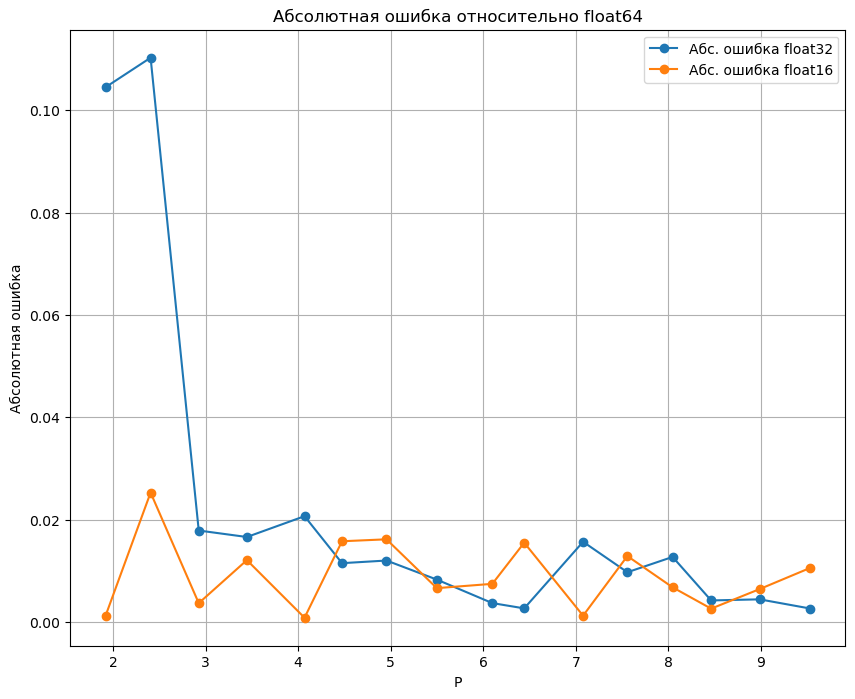

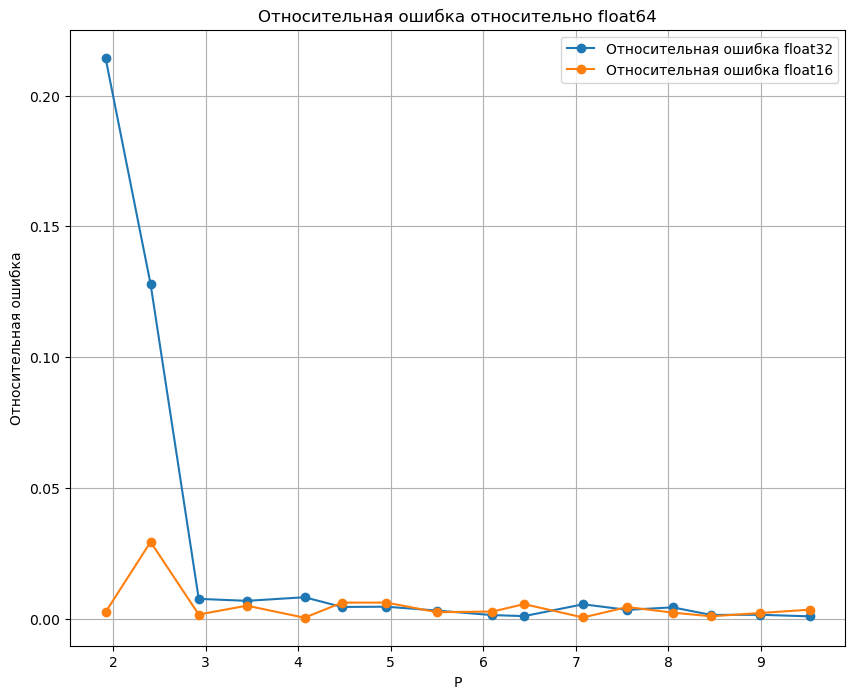

In [9]:
plt.figure()
for key, (abs_err, _) in errors.items():
    plt.plot(P_arrays['float64'], abs_err, marker='o', linestyle='-', label=f'Абс. ошибка {key}')
plt.xlabel('P')
plt.ylabel('Абсолютная ошибка')
plt.title('Абсолютная ошибка относительно float64')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
for key, (_, rel_err) in errors.items():
    plt.plot(P_arrays['float64'], rel_err, marker='o', linestyle='-', label=f'Относительная ошибка {key}')
plt.xlabel('P')
plt.ylabel('Относительная ошибка')
plt.title('Относительная ошибка относительно float64')
plt.legend()
plt.grid(True)
plt.show()

Строим столбчатую диаграмму времени работы для каждого типа данных

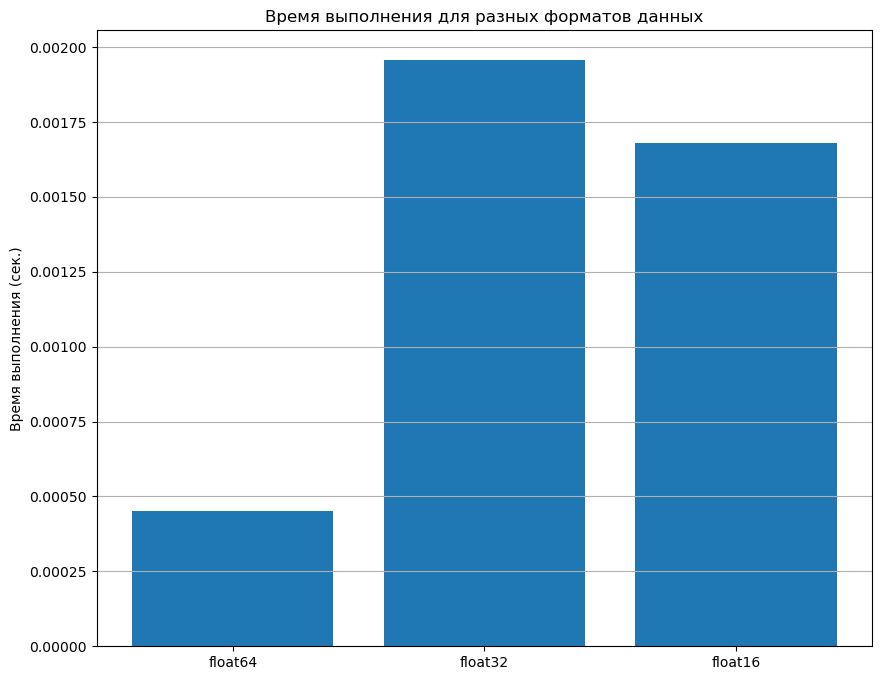

In [10]:
plt.figure()
plt.bar(list(times.keys()), list(times.values()))
plt.ylabel('Время выполнения (сек.)')
plt.title('Время выполнения для разных форматов данных')
plt.grid(axis='y')
plt.show()

Вычисляем число верных значащих цифр (на основе средней относительной ошибки)

In [13]:
correct_digits = {}
for key, (_, rel_err) in errors.items():
    # Выбираем только ненулевые ошибки для корректного вычисления логарифма
    valid_rel = rel_err[rel_err > 0]
    if valid_rel.size > 0:
        avg_rel_error = np.mean(valid_rel)
        correct_digits[key] = -np.log10(avg_rel_error)
    else:
        correct_digits[key] = np.inf


print("Среднее число верных значащих цифр (относительно float64):")
for key, digits in correct_digits.items():
    print(f"{key}: {digits:.2f}")

Среднее число верных значащих цифр (относительно float64):
float32: 1.61
float16: 2.33


# Выводы
1. В результате экспериментов видно, что использование float32 и особенно float16 даёт заметное увеличение относительной ошибки,
    что отражается на числе корректных значащих цифр. Это связано с ограниченной точностью представления чисел.

2. Время выполнения для float16 может быть меньше, однако устойчивость и точность метода ухудшаются.
   
3. При выборе начального приближения фиксированное значение 0.5 может работать не для всех P,
    поэтому в практическом применении может потребоваться адаптивный выбор начального приближения.
    
4. По результатам профилирования (см. ячейку с %lprun) видно, что основное время тратится на вычисление f(x) и df(x)
    внутри цикла, что является типичным узким местом в численных методах.